In [1]:
### Visualizations
import seaborn as sns
import matplotlib.pyplot as plt

### Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV

### Preprocessing and Feature Selection
from sklearn.feature_selection import mutual_info_classif, SelectPercentile
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from category_encoders import CountEncoder

### Models
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import (
    BaggingClassifier,
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
)

### Model Analysis
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import (
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
)
from sklearn.preprocessing import label_binarize

### Misc
import pandas as pd
import numpy as np
import os
import requests
import time
import warnings
from joblib import dump, load
from scipy import stats
from IPython.display import display
import dataframe_image as dfi
import re

In [2]:
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("deep")
plt.rcParams["axes.grid"] = False
plt.rcParams["axes.grid"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
warnings.filterwarnings("ignore")

In [83]:
telegram_api_token = os.getenv("telegram_api_token")
telegram_chat_id = os.getenv("telegram_chat_id")


def notify(text="Execution completed."):
    if telegram_api_token and telegram_chat_id:
        requests.post(
            "https://api.telegram.org/"
            + "bot{}/sendMessage".format(telegram_api_token),
            params=dict(chat_id=telegram_chat_id, text=text),
        )
    else:
        pass


def compare_models(gs, features_of_interest=None, round=2):
    results = {
        key: gs.cv_results_[key]
        for key in [
            "mean_train_score",
            "std_train_score",
            "mean_test_score",
            "std_test_score",
            "params",
        ]
    }
    results_df = pd.DataFrame(
        {
            "model": [type(params["model"]).__name__ for params in results["params"]],
            "model_parameters": [
                {
                    key: value
                    for key, value in params.items()
                    if key == "model" or key.startswith("model__")
                }
                for params in results["params"]
            ],
            "preprocessing": [
                getattr(params.get("preprocessing", None), "name", "None")
                for params in results["params"]
            ],
            **results,
        }
    )

    results_df["F1 Train Score"] = (
        results_df["mean_train_score"].round(round).astype(str)
        + " ± "
        + results_df["std_train_score"].round(round).astype(str)
    )
    results_df["F1 Validation Score"] = (
        results_df["mean_test_score"].round(round).astype(str)
        + " ± "
        + results_df["std_test_score"].round(round).astype(str)
    )

    numerical_cols = results_df.select_dtypes(include="number").columns
    results_df[numerical_cols] = results_df[numerical_cols].round(round)

    if features_of_interest:
        for key, col_name in features_of_interest.items():
            results_df[col_name] = results_df["params"].apply(lambda x: x.get(key))

    desired_last_columns = ["F1 Train Score", "F1 Validation Score"]
    other_columns = [
        col for col in results_df.columns if col not in desired_last_columns
    ]
    results_df = results_df[other_columns + desired_last_columns]
    return results_df.drop(
        [
            "params",
            "mean_train_score",
            "std_train_score",
            "mean_test_score",
            "std_test_score",
        ],
        axis=1,
    )


def transform_zip(zip_code):
    zip_code_str = str(zip_code)
    if (
        len(zip_code_str) < 5
        or zip_code_str.startswith("1")
        or zip_code_str.startswith("2")
        or zip_code_str.startswith("3")
        or zip_code_str.startswith("4")
    ):
        return "Eastern"
    elif (
        (zip_code_str.startswith("5"))
        | (zip_code_str.startswith("6"))
        | (zip_code_str.startswith("7"))
        | (zip_code_str.startswith("8"))
    ):
        return "Central"
    elif zip_code_str.startswith("9"):
        return "Western"


def custom_mutual_info_classif(X, y):
    return mutual_info_classif(X, y, n_neighbors=35)


def analyse_best_model(gs):
    best_model = gs.best_estimator_
    y_pred = best_model.predict(X)

    # Classification Report
    report_dict = classification_report(y, y_pred, zero_division=1, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose().round(2)
    display(report_df)

    cm = confusion_matrix(y, y_pred, normalize="true") * 100
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=gs.best_estimator_.classes_
    )
    fig, ax = plt.subplots()
    disp = disp.plot(cmap="Greys", ax=ax, values_format=".0f")
    disp.im_.set_clim(0, 100)

    plt.title("Confusion Matrix\n (row-wise percentages)")
    plt.xticks(rotation=90)
    plt.show()

    # Curves
    classes = list(set(y))
    y_test_binarized = label_binarize(y, classes=classes)

    # Predict probabilities for each class
    y_pred_proba = best_model.predict_proba(X)

    curves, axes = plt.subplots(1, 2, figsize=(16, 6))

    # ROC Curve
    ax = axes[0]
    for i, class_label in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=f"Class {class_label} (AUC = {roc_auc:.2f})")

    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Multiclass ROC Curve")
    ax.legend(loc="lower left", bbox_to_anchor=(1.1, 0.0))

    # Precision-Recall Curve
    ax = axes[1]
    for i, class_label in enumerate(classes):
        precision, recall, _ = precision_recall_curve(
            y_test_binarized[:, i], y_pred_proba[:, i]
        )
        avg_precision = average_precision_score(
            y_test_binarized[:, i], y_pred_proba[:, i]
        )
        ax.plot(
            recall, precision, label=f"Class {class_label} (AP = {avg_precision:.2f})"
        )

    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title("Multiclass Precision-Recall Curve")
    ax.legend(loc="lower left", bbox_to_anchor=(1.1, 0.0))

    plt.tight_layout()
    plt.show()

    return report_df, cm, curves


def get_predictions_csv(gs):
    y_test = gs.best_estimator_.predict(test)
    predictions = pd.DataFrame(
        y_test, columns=["Claim Injury Type"], index=test.index
    ).reset_index()
    predictions.to_csv("predictions.csv", index=False)


def export_df(df, file_name, dpi=300):
    default_path = "./figures/"

    if not file_name.endswith(".png"):
        file_name += ".png"
    full_path = os.path.join(default_path, file_name)

    styled_df = (
        df.style.hide(axis="index")
        .set_table_styles(
            [
                {"selector": "tr", "props": [("border-top", "1px solid black")]},
                {
                    "selector": "thead tr",
                    "props": [("border-bottom", "2px solid black")],
                },
                {
                    "selector": "",
                    "props": [("border", "none")],
                },
            ]
        )
        .set_properties(**{"background-color": "white", "color": "black"})
    ).format(precision=2)

    dfi.export(styled_df, full_path, dpi=dpi)

In [4]:
train = pd.read_csv("./resources/train_data.csv", low_memory=False)
test = pd.read_csv("./resources/test_data.csv")
us_zips = pd.read_csv("./resources/zip_code_database.csv")
# us_zips = pd.read_csv(
# "https://drive.google.com/uc?id=1B4JYYlV6KFHMgKdylldtIT14RAfsPy1K&export=download")

In [5]:
# Drop duplicates
train = train.drop_duplicates()

# Define Claim Identifier as the index
train.set_index("Claim Identifier", inplace=True)
test.set_index("Claim Identifier", inplace=True)

# Drop rows that have missing values in the target
train = train.dropna(subset=["Claim Injury Type"])

# Drop cols that are not on test dataset
train = train.drop(columns=["Agreement Reached", "WCB Decision"])

In [6]:
cause_injury = {
    "I. Burn or Scald - Heat or Cold Exposures - Contact With": [
        "1",
        "2",
        "3",
        "4",
        "5",
        "6",
        "7",
        "8",
        "9",
        "11",
        "14",
        "84",
    ],
    "II. Caught In, Under or Between": ["10", "12", "13", "20"],
    "III. Cut, Puncture, Scrape Injured By": ["15", "16", "17", "18", "19"],
    "IV. Fall, Slip or Trip Injury": [
        "25",
        "26",
        "27",
        "28",
        "29",
        "30",
        "31",
        "32",
        "33",
    ],
    "V. Motor Vehicle": ["40", "41", "45", "46", "47", "48", "50"],
    "VI. Strain or Injury By": [
        "52",
        "53",
        "54",
        "55",
        "56",
        "57",
        "58",
        "59",
        "60",
        "61",
        "97",
    ],
    "VII. Striking Against or Stepping On": [
        "65",
        "66",
        "67",
        "68",
        "69",
        "70",
    ],
    "VIII. Struck or Injured By": [
        "74",
        "75",
        "76",
        "77",
        "78",
        "79",
        "80",
        "81",
        "85",
        "86",
    ],
    "IX. Rubbed or Abraded By": ["94", "95"],
    "X. Miscellaneous Causes": [
        "82",
        "83",
        "87",
        "88",
        "89",
        "90",
        "91",
        "93",
        "96",
        "98",
        "99",
    ],
}

nature_injury = {
    "specific_injury": [
        "1",
        "2",
        "3",
        "4",
        "7",
        "10",
        "13",
        "16",
        "19",
        "22",
        "25",
        "28",
        "30",
        "31",
        "32",
        "34",
        "36",
        "37",
        "38",
        "40",
        "41",
        "42",
        "43",
        "46",
        "47",
        "49",
        "52",
        "53",
        "54",
        "55",
        "58",
        "59",
    ],
    "occupational_disease": [
        "60",
        "61",
        "62",
        "63",
        "64",
        "65",
        "66",
        "67",
        "68",
        "69",
        "70",
        "71",
        "72",
        "73",
        "74",
        "75",
        "76",
        "77",
        "78",
        "79",
        "80",
        "83",
    ],
    "multiple_injuries": ["90", "91"],
}
body_part = {
    "head": [
        "10",
        "11",
        "12",
        "13",
        "13A",
        "13B",
        "13C",
        "14",
        "14A",
        "14B",
        "14C",
        "15",
        "16",
        "17",
        "18",
        "19",
    ],
    "neck": ["20", "21", "22", "23", "24", "25", "26"],
    "upper_extremities": [
        "30",
        "31",
        "32",
        "33",
        "34",
        "35",
        "36",
        "36A",
        "36B",
        "36C",
        "36D",
        "36E",
        "36F",
        "36G",
        "36H",
        "36I",
        "36J",
        "36K",
        "36L",
        "36M",
        "36N",
        "36O",
        "36P",
        "37",
        "37A",
        "37B",
        "37C",
        "38",
        "39",
    ],
    "trunk": [
        "40",
        "41",
        "42",
        "43",
        "44",
        "45",
        "46",
        "47",
        "48",
        "49",
        "60",
        "61",
        "62",
        "63",
    ],
    "lower_extremities": [
        "50",
        "51",
        "52",
        "53",
        "54",
        "55",
        "56",
        "57",
        "57A",
        "57B",
        "57C",
        "57D",
        "57E",
        "57F",
        "57G",
        "58",
        "58A",
        "58B",
        "58C",
    ],
    "multiple_body_parts": ["64", "65", "66", "90", "91", "99"],
}

In [7]:
missing_dict = {
    col: round(train[col].isna().sum() * 100 / len(train), 2) for col in train.columns
}

missing_df = pd.DataFrame(
    list(missing_dict.items()), columns=["Column", "Missing Percentage"]
)

missing_df[missing_df["Missing Percentage"] > 50].sort_values(
    by="Missing Percentage", ascending=False
)

,Column,Missing Percentage
21,OIICS Nature of Injury Description,100.00
17,IME-4 Count,76.86
15,First Hearing Date,73.73
8,C-3 Date,67.38


In [8]:
# Independent variables
X = train.drop(["Claim Injury Type"], axis=1)

# Dependent variable
y = train[["Claim Injury Type"]]
y = y.to_numpy().ravel()

In [9]:
# Numeric columns
num_cols = [
    "Age at Injury",
    "Average Weekly Wage",
    "Birth Year",
    "IME-4 Count",
    "Accident Date",
    "Assembly Date",
    "C-2 Date",
    "C-3 Date",
    "First Hearing Date",
]

# Categorical columns
cat_cols = [
    "Carrier Name",
    "County of Injury",
    "Medical Fee Region",
    "Industry Code",
    "Industry Code Description",
    "District Name",
    "WCIO Cause of Injury Code",
    "WCIO Cause of Injury Description",
    "WCIO Nature of Injury Code",
    "WCIO Nature of Injury Description",
    "WCIO Part Of Body Code",
    "WCIO Part Of Body Description",
    "Zip Code",
    "OIICS Nature of Injury Description",
    "Accident Date",
]

# Binary columns
bin_cols = [
    "Alternative Dispute Resolution",
    "Attorney/Representative",
    "COVID-19 Indicator",
    "Gender",
    "Accident Date",
    "C-2 Date",
    "C-3 Date",
    "First Hearing Date",
    "Assembly Date",
    "Age at Injury",
]

# Preprocessing Pipeline

## Custom Classes

In [10]:
# _______________________NUM PIPELINE_______________________
class MissingValueImputer_Numeric(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """
        Filling Missing values.
        """
        X = X.copy()

        # Birth Year or Age at Injury are NA
        # Ensure 'Accident Date' is in datetime format
        X["Accident Date"] = pd.to_datetime(X["Accident Date"], errors="coerce")
        # Extract the year from 'Accident Date' for later computations
        X["Accident Year"] = X["Accident Date"].dt.year
        # Imputing calculated Birth Year / Age at Injury
        X.loc[(X["Birth Year"].isna()) & (X["Age at Injury"].notna()), "Birth Year"] = (
            X["Accident Year"] - X["Age at Injury"]
        )
        X.loc[
            (X["Age at Injury"].isna()) & (X["Birth Year"].notna()), "Age at Injury"
        ] = (X["Accident Year"] - X["Birth Year"])
        # Drop the 'Accident Year' column after computation
        X.drop(columns=["Accident Year"], inplace=True)

        # After verifying that there where no zeros in IME-4 Count, it was concluded that NAs most likely represented zeros
        X["IME-4 Count"] = X["IME-4 Count"].fillna(0)

        # Most missing values in dates seem to be meaningful, as they likely mean the event never occured. In order to preserve their meaning, we will fill them with a clearly invalid future placeholder.
        X["First Hearing Date"] = X["First Hearing Date"].fillna(
            pd.Timestamp("2100-01-01")
        )
        X["C-2 Date"] = X["C-2 Date"].fillna(pd.Timestamp("2100-01-01"))

        return X


class AnomalyFixer_Numeric(BaseEstimator, TransformerMixin):
    """
    Transformer to handle anomalies such as zero or invalid values in columns like 'Age at Injury' and 'Birth Year'.
    """

    def __init__(self):
        self.medians = {}

    def fit(self, X, y=None):
        """
        Fit the transformer by computing median values for anomaly correction.
        """
        X = X.copy()

        # Ensure 'Accident Date' is in datetime format
        X["Accident Date"] = pd.to_datetime(X["Accident Date"], errors="coerce")

        # Calculate medians for date correction
        for col in ["C-2 Date", "C-3 Date", "Assembly Date", "First Hearing Date"]:
            X[col] = pd.to_datetime(X[col], errors="coerce")
            self.medians[col] = X[col].median()

        return self

    def transform(self, X):
        """
        Transform the data by fixing anomalies such as zeros in 'Age at Injury' and 'Birth Year'.
        """
        X = X.copy()

        # Birth Year or Age at Injury are equal to zero
        # Ensure 'Accident Date' is in datetime format
        X["Accident Date"] = pd.to_datetime(X["Accident Date"], errors="coerce")
        # Extract the year from 'Accident Date' for later computations
        X["Accident Year"] = X["Accident Date"].dt.year
        # Imputing calculated Birth Year / Age at Injury
        X.loc[(X["Birth Year"] == 0) & (X["Age at Injury"] != 0), "Birth Year"] = (
            X["Accident Year"] - X["Age at Injury"]
        )
        X.loc[(X["Age at Injury"] == 0) & (X["Birth Year"] != 0), "Age at Injury"] = (
            X["Accident Year"] - X["Birth Year"]
        )
        # Drop the 'Accident Year' column after computation
        X.drop(columns=["Accident Year"], inplace=True)

        # Fixing cases where Accident Date happens after other dates
        for col in ["C-2 Date", "C-3 Date", "Assembly Date", "First Hearing Date"]:
            X[col] = pd.to_datetime(X[col], errors="coerce")
            condition = (X[col] - X["Accident Date"]).dt.days < 0
            X.loc[condition, col] = self.medians[col]

        return X


class Num_Feature_Engineering(BaseEstimator, TransformerMixin):

    def __init__(
        self,
        date_columns=[
            "Accident Date",
            "Assembly Date",
            "C-2 Date",
            "C-3 Date",
            "First Hearing Date",
        ],
        birth_column="Birth Year",
        weekly_wage_column="Average Weekly Wage",
    ):
        """
        Transformer to process both date columns and numeric features.

        This class combines date processing (calculating date-based features) and numeric feature engineering
        (calculating features like age, age interactions, etc.) into one step.

        Parameters:
        ----------
        - date_columns: list of str
            List of columns containing date data to be processed.
        - birth_column: str, default="Birth Year"
            The column name containing the birth year of individuals.
        - weekly_wage_column: str, default="Average Weekly Wage"
            The column name for average weekly wage to be used in feature interactions.
        """
        self.date_columns = date_columns
        self.birth_column = birth_column
        self.weekly_wage_column = weekly_wage_column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Step 1: Convert date columns to datetime and calculate date-based features
        for col in self.date_columns:
            X[col] = pd.to_datetime(X[col])

        X["Accident to Assembly Days"] = (
            X["Assembly Date"] - X["Accident Date"]
        ).dt.days
        X["Accident to First Hearing Days"] = (
            X["First Hearing Date"] - X["Accident Date"]
        ).dt.days
        X["Accident to C-2 Days"] = (X["C-2 Date"] - X["Accident Date"]).dt.days
        X["Accident to C-3 Days"] = (X["C-3 Date"] - X["Accident Date"]).dt.days

        # Step 2: Generate additional numeric features based on birth year and other columns
        current_year = pd.Timestamp.now().year
        X["Age"] = current_year - X[self.birth_column]

        # Create year, month, and quarter features from 'Accident Date'
        X["Accident Year"] = X["Accident Date"].dt.year
        X["Accident Month"] = X["Accident Date"].dt.month
        X["Accident Quarter"] = X["Accident Date"].dt.quarter

        # Additional transformations using Age
        X["Relative Age at Injury"] = X["Age"] - X["Age at Injury"]
        X["Age Squared"] = X["Age"] ** 2
        X["Age x Weekly Wage"] = X["Age"] * X[self.weekly_wage_column]

        # Drop the original date columns after transformation
        X = X.drop(self.date_columns, axis=1)

        return X


class OutlierCapper(BaseEstimator, TransformerMixin):
    """
    Transformer to cap outliers in a DataFrame.
    Can use IQR or percentile method.

    Parameters:
    ----------
    method : str, optional (default="iqr")
        The method to use for outlier capping. Options are:
        - "iqr": Use the Interquartile Range (IQR) to define caps.
        - "percentile": Use lower and upper percentiles to define caps.

    lower_quantile : float, optional (default=0.01)
        The lower quantile for capping when using the "percentile" method.
    upper_quantile : float, optional (default=0.99)
        The upper quantile for capping when using the "percentile" method.
    iqr_multiplier : float, optional (default=1.5)
        The multiplier for the IQR to define caps when using the "iqr" method.

    Returns:
    ----------
    - DataFrame : The transformed DataFrame with the values capped.
    """

    def __init__(
        self, method="iqr", lower_quantile=0.01, upper_quantile=0.99, iqr_multiplier=1.5
    ):

        self.method = method
        self.lower_quantile = lower_quantile
        self.upper_quantile = upper_quantile
        self.iqr_multiplier = iqr_multiplier

    def fit(self, X, y=None):

        X = pd.DataFrame(X)
        self.caps_ = {}

        for col in X.columns:
            if self.method == "iqr":
                Q1 = X[col].quantile(0.25)
                Q3 = X[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_cap = Q1 - self.iqr_multiplier * IQR
                upper_cap = Q3 + self.iqr_multiplier * IQR

            elif self.method == "percentile":
                lower_cap = X[col].quantile(self.lower_quantile)
                upper_cap = X[col].quantile(self.upper_quantile)

            self.caps_[col] = (lower_cap, upper_cap)
        return self

    def transform(self, X):
        X = pd.DataFrame(X)
        for col in X.columns:
            lower_cap, upper_cap = self.caps_[col]
            X[col] = X[col].clip(lower=lower_cap, upper=upper_cap)
        return X


# _______________________CATEGORICAL PIPELINE_______________________


class Categorical_Feature_Engineering(BaseEstimator, TransformerMixin):

    def __init__(
        self,
        columns_to_modify=[
            "WCIO Cause of Injury Code",
            "WCIO Nature of Injury Code",
            "WCIO Part Of Body Code",
            "Zip Code",
            "Accident Date",
        ],
        dict_mappings=[cause_injury, nature_injury, body_part],
    ):
        """
        Transformer to group code features into supra codes.
        Drops the original date columns.

        Parameters:
        ----------
        - columns_to_modify: lst of str, optional(default=["WCIO Cause of Injury Code", "WCIO Nature of Injury Code","WCIO Part Of Body Code"])
        List of columns with date data to be grouped.
        - dict_mappings: lst of dict, optional(default=[cause_injury, nature_injury, body_part])
        List of dictionaries mapping codes to supra codes.

        Returns:
        ----------
        - DataFrame : The transformed DataFrame with the new features and without the original columns.
        """

        self.columns_to_modify = columns_to_modify
        self.dict_mappings = dict_mappings

    def fit(self, X, y=None):
        return self

    def transform(self, X):

        X = X.copy()
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        # CAUSE OF INJURY
        code_to_category = {
            code: category for category, codes in cause_injury.items() for code in codes
        }
        X["WCIO Cause of Injury Code SUPRA"] = X["WCIO Cause of Injury Code"].apply(
            lambda code: code_to_category.get(str(code).split(".")[0], np.nan)
        )

        # NATURE OF INJURY

        nature_code_to_category = {
            code: category
            for category, codes in {
                "Specific Injury": nature_injury["specific_injury"],
                "Occupational Disease or Cumulative Injury": nature_injury[
                    "occupational_disease"
                ],
                "Multiple Injuries": nature_injury["multiple_injuries"],
            }.items()
            for code in codes
        }

        X["WCIO Nature of Injury Code SUPRA"] = X["WCIO Nature of Injury Code"].apply(
            lambda code: nature_code_to_category.get(str(code).split(".")[0], np.nan)
        )

        # PART OF BODY

        body_part_to_category = {
            code: category
            for category, codes in {
                "Head": body_part["head"],
                "Neck": body_part["neck"],
                "Upper Extremities": body_part["upper_extremities"],
                "Trunk": body_part["trunk"],
                "Lower Extremities": body_part["lower_extremities"],
                "Multiple Body Parts": body_part["multiple_body_parts"],
            }.items()
            for code in codes
        }

        X["WCIO Part Of Body Code SUPRA"] = X["WCIO Part Of Body Code"].apply(
            lambda code: body_part_to_category.get(str(code).split(".")[0], np.nan)
        )

        # ZIP CODE

        # Remove the .0 at the end of the Zip Codes who previously had it.
        X["Zip Code"] = X["Zip Code"].replace(r"\.0$", "", regex=True)

        # Find out the missing and the non-missing Zip Codes ('00000' and '99999' were included because they are common placeholders)
        zips = X[
            ~(
                (X["Zip Code"].isna())
                | (X["Zip Code"] == "00000")
                | (X["Zip Code"] == "99999")
            )
        ]
        zips["Zip Code"] = zips["Zip Code"].astype(str)
        missing_zips = X[
            (X["Zip Code"].isna())
            | (X["Zip Code"] == "00000")
            | (X["Zip Code"] == "99999")
        ]

        # From the non-missing Zip Codes, find out which ones are in the format of a five digit number with no space or special characters and the others that are not
        regular_zips = zips[zips["Zip Code"].str.fullmatch(r"^\d{1,5}$")]
        regular_zips["Zip Code"] = regular_zips["Zip Code"].astype(int)
        no_regular_zips = zips[~zips["Zip Code"].str.fullmatch(r"^\d{1,5}$")]

        # From the regular Zip Codes, find out which ones are on the american dataset containing all USA Zip Codes and the ones who are not.
        american_zips = regular_zips[regular_zips["Zip Code"].isin(us_zips["zip"])]
        no_american_zips = regular_zips[~regular_zips["Zip Code"].isin(us_zips["zip"])]

        # For the american Zip Codes, we find out their region based on the first digit of their Zip Code
        X.loc[american_zips.index, "Region"] = american_zips["Zip Code"].apply(
            transform_zip
        )

        # For the remaining not missing Zip Codes, we mention that they are not from the USA
        X.loc[no_american_zips.index, "Region"] = "Not US"
        X.loc[no_regular_zips.index, "Region"] = "Not US"

        # Missing values will be referred to as so
        X.loc[missing_zips.index, "Region"] = "Missing"

        # ACCIDENT SEASON
        X["Accident Date"] = pd.to_datetime(X["Accident Date"], errors="coerce")
        X["Accident Season"] = X["Accident Date"].dt.month
        X["Accident Season"] = X["Accident Season"].map(
            {
                1: "Winter",
                2: "Winter",
                3: "Spring",
                4: "Spring",
                5: "Spring",
                6: "Summer",
                7: "Summer",
                8: "Summer",
                9: "Fall",
                10: "Fall",
                11: "Fall",
                12: "Winter",
            }
        )

        return X.drop(self.columns_to_modify, axis=1)


# _______________________BINARY PIPELINE_______________________


class Binary_Feature_Engineering(BaseEstimator, TransformerMixin):

    def __init__(
        self,
        columns=[
            "Gender",
            "Alternative Dispute Resolution",
            "Attorney/Representative",
            "COVID-19 Indicator",
            "Accident Date",
            "C-2 Date",
            "C-3 Date",
            "First Hearing Date",
            "Assembly Date",
            "Age at Injury",
        ],
    ):
        """
        Transformer to calculate new binary features.
        Drops the original non binary columns.


        Parameters:
        ----------
        - columns: lst of str, required
        List of columns to be used during feature engineering.

        Returns:
        ----------
        - DataFrame : The transformed DataFrame with the new features and without the original non binary.
        """
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Convert to Binary
        X["Male"] = np.select(
            [
                X["Gender"] == "M",
                X["Gender"] == "F",
                X["Gender"] == "X",
                X["Gender"] == "U",
            ],
            [1, 0, 0, 0],
        )

        convert_to_binary_cols = [
            "Alternative Dispute Resolution",
            "Attorney/Representative",
            "COVID-19 Indicator",
        ]
        for col in convert_to_binary_cols:
            X[col] = np.select(
                [
                    X[col] == "Y",
                    X[col] == "N",
                    ~X[col].isin(["Y", "N"]),
                ],
                [1, 0, np.nan],
            )

        # Convert columns to datetime
        date_columns = [
            "Accident Date",
            "C-2 Date",
            "C-3 Date",
            "First Hearing Date",
            "Assembly Date",
        ]
        for col in date_columns:
            X[col] = pd.to_datetime(
                X[col], errors="coerce"
            )  # Convert to datetime, coercing invalid values to NaT

        # Missing Date Flags (Assembly Date is never missing)
        for col in ["Accident Date", "C-2 Date", "C-3 Date", "First Hearing Date"]:
            X[f"Is Missing {col}"] = X[col].isna().astype(int)

        # Is weekend features (First Hearing Date is never in the weekend)
        X[" Is Weekend Accident Date"] = (
            X["Accident Date"].dt.weekday.isin([5, 6]).astype(int)
        )
        X["Is Weekend C-2 Date"] = X["C-2 Date"].dt.weekday.isin([5, 6]).astype(int)
        X["Is Weekend C-3 Date"] = X["C-3 Date"].dt.weekday.isin([5, 6]).astype(int)
        X["Is Weekend Assembly Date"] = (
            X["Assembly Date"].dt.weekday.isin([5, 6]).astype(int)
        )

        # Create the binary flag Accident Dates during COVID years
        covid_start = pd.Timestamp("2020-01-01")
        covid_end = pd.Timestamp("2022-12-31")
        X["Is COVID Accident Date"] = (
            X["Accident Date"].between(covid_start, covid_end).astype(int)
        )

        # Age Features
        # Create binary flag "Is Worker Under 30"
        X["Is Worker Under 30"] = (X["Age at Injury"] < 30).astype(int)

        # Create binary flag "Is Worker Over 50"
        X["Is Worker Over 50"] = (X["Age at Injury"] > 50).astype(int)

        # Dropping non-binary features
        return X.drop(
            columns=[
                "Accident Date",
                "C-2 Date",
                "C-3 Date",
                "Assembly Date",
                "First Hearing Date",
                "Age at Injury",
                "Gender",
            ],
            axis=1,
        )

In [11]:
class Transformer_Numeric(BaseEstimator, TransformerMixin):
    """
    Transformer to apply log or Box-Cox transformation to columns with high skewness and/or kurtosis.

    Parameters:
    ----------
    strategy : str, optional (default='log')
        The transformation strategy to use. Options are 'log' or 'boxcox'.

    skew_threshold : float, optional (default=1)
        The skewness threshold above which transformation is applied.

    kurtosis_threshold : float, optional (default=3)
        The kurtosis threshold above which log transformation is applied (only used for 'log' strategy).

    columns : list of str, optional (default=None)
        List of columns to check for skewness and kurtosis.
    """

    def __init__(
        self, strategy="log", skew_threshold=1, kurtosis_threshold=3, columns=None
    ):
        self.strategy = strategy
        self.skew_threshold = skew_threshold
        self.kurtosis_threshold = kurtosis_threshold
        self.columns = columns

    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        self.columns_ = (
            self.columns if self.columns else X.select_dtypes(include=np.number).columns
        )
        self.cols_to_transform_ = []
        self.lambdas_ = {}

        for col in self.columns_:
            skewness = X[col].skew()
            kurtosis = X[col].kurtosis()

            if self.strategy == "log":
                if (
                    skewness > self.skew_threshold
                    and kurtosis > self.kurtosis_threshold
                ):
                    self.cols_to_transform_.append(col)
            elif self.strategy == "boxcox":
                if skewness > self.skew_threshold:
                    self.cols_to_transform_.append(col)
                    # Fit Box-Cox transformation and store lambda
                    transformed_data, lambda_ = stats.boxcox(
                        X[col] + 1
                    )  # Adding a  constant to handle zeros
                    self.lambdas_[col] = lambda_
        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()

        for col in self.cols_to_transform_:
            if self.strategy == "log":
                X[col] = np.log1p(
                    X[col]
                )  # log1p handles zero values by using log(1 + x)
            elif self.strategy == "boxcox":
                X[col] = stats.boxcox(X[col] + 1, lmbda=self.lambdas_[col])

        return X

## Pipeline

In [12]:
num_pipeline = Pipeline(
    steps=[
        ("missing_values", MissingValueImputer_Numeric()),
        ("anomaly_fixer", AnomalyFixer_Numeric()),
        ("date_to_num", Num_Feature_Engineering()),
        ("imputation", SimpleImputer(strategy="median")),
        ("outlier_capping", OutlierCapper(method="iqr", iqr_multiplier=1.5)),
    ]
)

cat_pipeline = Pipeline(
    steps=[
        (
            "feature_engineering",
            Categorical_Feature_Engineering(),
        ),
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("encoder", CountEncoder(return_df=True)),
    ]
)


bin_pipeline = Pipeline(
    steps=[
        ("convert_to_binary", Binary_Feature_Engineering()),
        ("impute", SimpleImputer(strategy="most_frequent")),
    ]
)

# Define baseline pipeline
baseline = Pipeline(
    steps=[
        (
            "column_transformer",
            ColumnTransformer(
                transformers=[
                    ("num_pipeline", num_pipeline, num_cols),
                    ("cat_pipeline", cat_pipeline, cat_cols),
                    ("bin_pipeline", bin_pipeline, bin_cols),
                ],
                remainder="drop",
                n_jobs=-1,
            ),
        ),
        ("union", FeatureUnion([("scaler", StandardScaler())])),
    ]
)

baseline.name = "baseline"

# FS Pipeline

## Estimate Optimal N Neighbors for Mutual Information

In [13]:
run = False

if run:
    pipeline = Pipeline(
        [
            ("preprocessing", None),
            ("model", None),
        ]
    )

    param_grid = [
        {
            "model": [KNeighborsClassifier()],
            "model__n_neighbors": range(5, 155, 5),
            "preprocessing": [baseline],
        },
    ]

    gs = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        scoring="f1_macro",
        cv=3,
        verbose=1,
        return_train_score=True,
        refit=False,
    )

    gs.fit(X, y)
    dump(gs, "./runs/estimate_KNN.joblib")
    notify()

else:
    estimate_knn_gs = load("./runs/estimate_KNN.joblib")

In [89]:
estimate_knn = compare_models(estimate_knn_gs, {"model__n_neighbors": "neighbors"})
estimate_knn = estimate_knn.drop("model_parameters", axis=1)
estimate_knn

,model,preprocessing,neighbors,F1 Train Score,F1 Validation Score
0,KNeighborsClassifier,baseline,5,0.44 ± 0.01,0.34 ± 0.01
1,KNeighborsClassifier,baseline,10,0.39 ± 0.01,0.34 ± 0.0
2,KNeighborsClassifier,baseline,15,0.37 ± 0.01,0.33 ± 0.0
3,KNeighborsClassifier,baseline,20,0.36 ± 0.01,0.33 ± 0.0
4,KNeighborsClassifier,baseline,25,0.35 ± 0.0,0.33 ± 0.0
5,KNeighborsClassifier,baseline,30,0.35 ± 0.0,0.33 ± 0.0
6,KNeighborsClassifier,baseline,35,0.34 ± 0.0,0.33 ± 0.0
7,KNeighborsClassifier,baseline,40,0.34 ± 0.0,0.32 ± 0.0
8,KNeighborsClassifier,baseline,45,0.34 ± 0.0,0.32 ± 0.0
9,KNeighborsClassifier,baseline,50,0.34 ± 0.0,0.32 ± 0.0


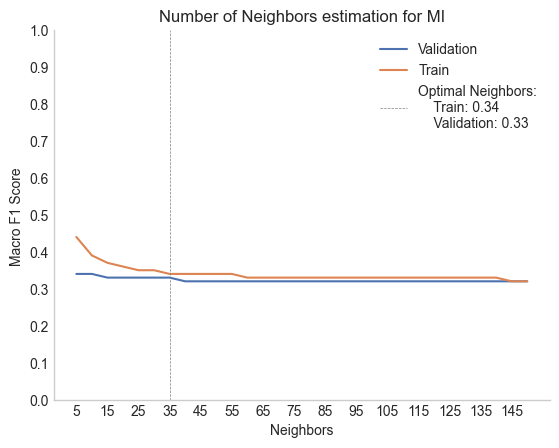

In [86]:
estimate_knn = compare_models(estimate_knn_gs, {"model__n_neighbors": "neighbors"})
estimate_knn["F1 Train Score"] = (
    estimate_knn["F1 Train Score"].str.split("±").str[0].str.strip().astype(float)
)
estimate_knn["F1 Validation Score"] = (
    estimate_knn["F1 Validation Score"].str.split("±").str[0].str.strip().astype(float)
)
train_score_35 = estimate_knn.loc[
    estimate_knn["neighbors"] == 35, "F1 Train Score"
].values[0]
validation_score_35 = estimate_knn.loc[
    estimate_knn["neighbors"] == 35, "F1 Validation Score"
].values[0]



sns.lineplot(
    x="neighbors",
    y="F1 Validation Score",

    data=estimate_knn,
    label="Validation",
)
sns.lineplot(x="neighbors", y="F1 Train Score", data=estimate_knn, label="Train")

plt.axvline(
    x=35,
    color="gray",
    linestyle="--",
    label=f"Optimal Neighbors:\n    Train: {train_score_35:.2f}\n    Validation: {validation_score_35:.2f}",
    linewidth=0.5,
)

plt.xticks(np.arange(5, 155, 10))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel("Macro F1 Score ")
plt.xlabel("Neighbors")
plt.legend()
plt.savefig("./figures/fs_neighbors.png", dpi=300, bbox_inches="tight")
plt.title("Number of Neighbors estimation for MI")


plt.show()

## Base Models

In [81]:
run = False

if run:

    start_time = time.time()

    pipeline = Pipeline(
        [
            ("preprocessing", None),
            (
                "feature_selection",
                SelectPercentile(
                    score_func=custom_mutual_info_classif, percentile=None
                ),
            ),
            ("model", None),
        ]
    )

    param_grid = [
        # Logistic Regression
        {
            "model": [LogisticRegression(max_iter=1000, class_weight="balanced")],
            "preprocessing": [baseline],
            "feature_selection__percentile": [50, 90, 70],
        },
        # Decision Tree
        {
            "model": [DecisionTreeClassifier(max_depth=15, class_weight="balanced")],
            "preprocessing": [baseline],
            "feature_selection__percentile": [50, 90, 70],
        },
        # K-Nearest Neighbors
        {
            "model": [KNeighborsClassifier(n_neighbors=35, weights="distance", p=1)],
            "preprocessing": [baseline],
            "feature_selection__percentile": [50, 90, 70],
        },
        # Gaussian Naive Bayes
        {
            "model": [GaussianNB()],
            "preprocessing": [baseline],
            "feature_selection__percentile": [50, 90, 70],
        },
        # MLP Classifier
        {
            "model": [MLPClassifier((20, 20), learning_rate_init=0.01, max_iter=1000)],
            "preprocessing": [baseline],
            "feature_selection__percentile": [50, 90, 70],
        },
    ]

    gs = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        scoring="f1_macro",
        cv=3,
        verbose=1,
        n_jobs=-1,
        return_train_score=True,
        refit=False,
    )

    gs.fit(X, y)
    dump(gs, "./runs/base_models.joblib")

    end_time = time.time()
    execution_time = end_time - start_time
    hours, remainder = divmod(execution_time, 3600)
    minutes, seconds = divmod(remainder, 60)
    notify(f"Execution completed in {int(hours)}:{int(minutes)}:{round(seconds)}")

else:
    base_models_gs = load("./runs/base_models.joblib")

In [ ]:
base_models_df = compare_models(
    base_models_gs, {"feature_selection__percentile": "FS Percentile"}
)
# export_df(base_models_df, "base_models")
base_models_df.sort_values(by="F1 Validation Score", ascending=False)

,model,model_parameters,preprocessing,FS Percentile,F1 Train Score,F1 Validation Score
13,MLPClassifier,"hidden_layer_sizes=(20, 20), learning_rate_init=0.01, max_iter=1000",baseline,90,0.39 ± 0.02,0.37 ± 0.01
14,MLPClassifier,"hidden_layer_sizes=(20, 20), learning_rate_init=0.01, max_iter=1000",baseline,70,0.37 ± 0.02,0.36 ± 0.02
4,DecisionTreeClassifier,"class_weight='balanced', max_depth=15",baseline,90,0.46 ± 0.01,0.34 ± 0.03
5,DecisionTreeClassifier,"class_weight='balanced', max_depth=15",baseline,70,0.46 ± 0.01,0.34 ± 0.03
6,KNeighborsClassifier,"n_neighbors=35, p=1, weights='distance'",baseline,50,1.0 ± 0.0,0.34 ± 0.01
8,KNeighborsClassifier,"n_neighbors=35, p=1, weights='distance'",baseline,70,1.0 ± 0.0,0.34 ± 0.01
12,MLPClassifier,"hidden_layer_sizes=(20, 20), learning_rate_init=0.01, max_iter=1000",baseline,50,0.36 ± 0.02,0.34 ± 0.01
7,KNeighborsClassifier,"n_neighbors=35, p=1, weights='distance'",baseline,90,1.0 ± 0.0,0.34 ± 0.0
3,DecisionTreeClassifier,"class_weight='balanced', max_depth=15",baseline,50,0.45 ± 0.01,0.33 ± 0.04
1,LogisticRegression,"class_weight='balanced', max_iter=1000",baseline,90,0.32 ± 0.0,0.3 ± 0.01


In [129]:
base_models_df = compare_models(
    base_models_gs, {"feature_selection__percentile": "FS Percentile"}
)
base_models_df["model_parameters"] = (
    base_models_df["model_parameters"]
    .apply(lambda text: (re.search(r"\((.*)\)", str(text), re.DOTALL).group(1)))
    .replace("", "base model")
    .str.replace("\n", "", regex=False)
)


export_df(base_models_df, "base_models")
base_models_df.sort_values(by="F1 Validation Score", ascending=False)

,model,model_parameters,preprocessing,FS Percentile,F1 Train Score,F1 Validation Score
13,MLPClassifier,"hidden_layer_sizes=(20, 20), learning_rate_init=0.01, max_iter=1000",baseline,90,0.39 ± 0.02,0.37 ± 0.01
14,MLPClassifier,"hidden_layer_sizes=(20, 20), learning_rate_init=0.01, max_iter=1000",baseline,70,0.37 ± 0.02,0.36 ± 0.02
4,DecisionTreeClassifier,"class_weight='balanced', max_depth=15",baseline,90,0.46 ± 0.01,0.34 ± 0.03
5,DecisionTreeClassifier,"class_weight='balanced', max_depth=15",baseline,70,0.46 ± 0.01,0.34 ± 0.03
6,KNeighborsClassifier,"n_neighbors=35, p=1, weights='distance'",baseline,50,1.0 ± 0.0,0.34 ± 0.01
8,KNeighborsClassifier,"n_neighbors=35, p=1, weights='distance'",baseline,70,1.0 ± 0.0,0.34 ± 0.01
12,MLPClassifier,"hidden_layer_sizes=(20, 20), learning_rate_init=0.01, max_iter=1000",baseline,50,0.36 ± 0.02,0.34 ± 0.01
7,KNeighborsClassifier,"n_neighbors=35, p=1, weights='distance'",baseline,90,1.0 ± 0.0,0.34 ± 0.0
3,DecisionTreeClassifier,"class_weight='balanced', max_depth=15",baseline,50,0.45 ± 0.01,0.33 ± 0.04
1,LogisticRegression,"class_weight='balanced', max_iter=1000",baseline,90,0.32 ± 0.0,0.3 ± 0.01


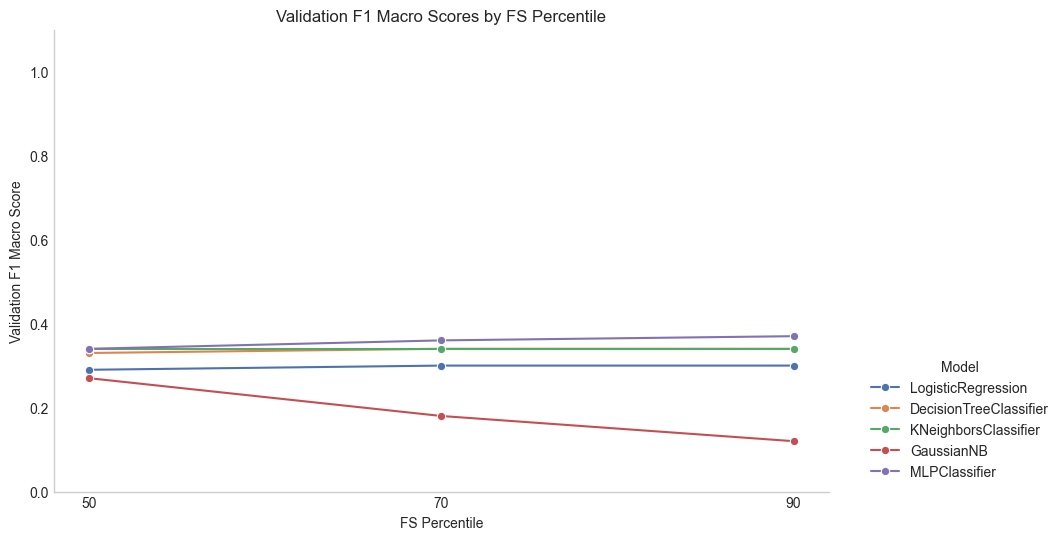

In [130]:
fs_differences = base_models_df[["FS Percentile", "F1 Validation Score", "model"]]

fs_differences["F1 Validation Score"] = (
    fs_differences["F1 Validation Score"]
    .str.split("±")
    .str[0]
    .str.strip()
    .astype(float)
)

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=fs_differences,
    x="FS Percentile",
    y="F1 Validation Score",
    hue="model",
    marker="o",
)

plt.xlabel("FS Percentile")
plt.ylabel("Validation F1 Macro Score")
plt.xticks(fs_differences["FS Percentile"].unique())
plt.ylim(0, 1.1)
plt.legend()
plt.legend(title="Model", loc="lower right", bbox_to_anchor=(1.3, 0))
plt.savefig(
    "./figures/basemodel_percentile_threshold.png", dpi=300, bbox_inches="tight"
)
plt.title("Validation F1 Macro Scores by FS Percentile")
plt.show()

## Ensemble Models

In [47]:
run = False

if run:

    start_time = time.time()

    pipeline = Pipeline(
        [
            ("preprocessing", None),
            (
                "feature_selection",
                SelectPercentile(
                    score_func=custom_mutual_info_classif, percentile=None
                ),
            ),
            ("model", None),
        ]
    )

    param_grid = [
        # Bagging with MLP
        {
            "model": [
                BaggingClassifier(
                    estimator=MLPClassifier(
                        (20, 20), learning_rate_init=0.01, max_iter=1000
                    ),
                    n_estimators=10,
                )
            ],
            "preprocessing": [baseline],
            "feature_selection__percentile": [90],
            "model__max_samples": [0.8, 1.0],
            "model__max_features": [0.8, 1.0],
        },
        # Random Forest
        {
            "model": [RandomForestClassifier()],
            "preprocessing": [baseline],
            "feature_selection__percentile": [90],
            "model__n_estimators": [100, 200],
            "model__max_depth": [5, 10],
            "model__min_samples_split": [2, 5],
        },
        # AdaBoost
        {
            "model": [AdaBoostClassifier()],
            "preprocessing": [baseline],
            "feature_selection__percentile": [90],
            "model__n_estimators": [50, 100],
            "model__learning_rate": [0.05, 0.1],
        },
        # Gradient Boosting
        {
            "model": [GradientBoostingClassifier()],
            "preprocessing": [baseline],
            "feature_selection__percentile": [90],
            "model__n_estimators": [50, 100],
            "model__learning_rate": [0.05, 0.1],
            "model__max_depth": [5, 10],
        },
    ]

    gs = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        scoring="f1_macro",
        cv=3,
        verbose=1,
        n_jobs=-1,
        return_train_score=True,
        refit=False,
    )

    gs.fit(X, y)
    dump(gs, "./runs/ensemble.joblib")

    end_time = time.time()
    execution_time = end_time - start_time
    hours, remainder = divmod(execution_time, 3600)
    minutes, seconds = divmod(remainder, 60)
    notify(f"Execution completed in {int(hours)}:{int(minutes)}:{round(seconds)}")

else:
    ensemble_models_gs = load("./runs/ensemble.joblib")

In [165]:
ensemble_models_df = compare_models(ensemble_models_gs)

ensemble_models_df.loc[
    ensemble_models_df["model"] == "BaggingClassifier", "model_parameters"
] = (
    ensemble_models_df.loc[
        ensemble_models_df["model"] == "BaggingClassifier", "model_parameters"
    ]
    .apply(
        lambda text: (
            re.search(r"estimator=MLPClassifier\(.*?\)\)(.*)", str(text), re.DOTALL)
            .group(0)
            .rstrip("))}")  # Remove trailing )) or }
            if re.search(r"estimator=MLPClassifier\(.*?\)\)(.*)", str(text), re.DOTALL)
            else None
        )
    )
    .str.replace("\n", "", regex=False)
    .str.replace("))", " ")
    .str.replace("'", "")
    .str.replace("model__", "", regex=False)
)

ensemble_models_df.loc[
    ensemble_models_df["model"] == "BaggingClassifier", "model_parameters"
] = (
    ensemble_models_df.loc[
        ensemble_models_df["model"] == "BaggingClassifier", "model_parameters"
    ]
    + ", n_estimators=10"
)

ensemble_models_df.loc[
    ensemble_models_df["model"] != "BaggingClassifier", "model_parameters"
] = (
    ensemble_models_df.loc[
        ensemble_models_df["model"] != "BaggingClassifier", "model_parameters"
    ]
    .apply(
        lambda text: (
            re.search(r"\)(.*)", str(text), re.DOTALL)
            .group(1)
            .strip()
            .lstrip(",")
            .rstrip("}")
            if re.search(r"\)(.*)", str(text), re.DOTALL)
            else None
        )
    )
    .str.replace("'", "", regex=False)
    .str.replace("model__", "", regex=False)
)

export_df(ensemble_models_df, "ensemble_models")
ensemble_models_df.sort_values(by="F1 Validation Score", ascending=False)

,model,model_parameters,preprocessing,F1 Train Score,F1 Validation Score
21,GradientBoostingClassifier,"learning_rate: 0.1, max_depth: 5, n_estimators: 100",baseline,0.48 ± 0.01,0.4 ± 0.01
20,GradientBoostingClassifier,"learning_rate: 0.1, max_depth: 5, n_estimators: 50",baseline,0.46 ± 0.01,0.4 ± 0.01
17,GradientBoostingClassifier,"learning_rate: 0.05, max_depth: 5, n_estimators: 100",baseline,0.52 ± 0.03,0.4 ± 0.01
16,GradientBoostingClassifier,"learning_rate: 0.05, max_depth: 5, n_estimators: 50",baseline,0.49 ± 0.02,0.39 ± 0.01
22,GradientBoostingClassifier,"learning_rate: 0.1, max_depth: 10, n_estimators: 50",baseline,0.72 ± 0.01,0.39 ± 0.01
19,GradientBoostingClassifier,"learning_rate: 0.05, max_depth: 10, n_estimators: 100",baseline,0.75 ± 0.01,0.39 ± 0.01
18,GradientBoostingClassifier,"learning_rate: 0.05, max_depth: 10, n_estimators: 50",baseline,0.7 ± 0.01,0.39 ± 0.01
23,GradientBoostingClassifier,"learning_rate: 0.1, max_depth: 10, n_estimators: 100",baseline,0.8 ± 0.01,0.38 ± 0.02
2,BaggingClassifier,"estimator=MLPClassifier(hidden_layer_sizes=(20, 20), learning_rate_init=0.01, max_iter=1000 , max_features: 1.0, max_samples: 0.8, n_estimators=10",baseline,0.4 ± 0.01,0.38 ± 0.02
0,BaggingClassifier,"estimator=MLPClassifier(hidden_layer_sizes=(20, 20), learning_rate_init=0.01, max_iter=1000 , max_features: 0.8, max_samples: 0.8, n_estimators=10",baseline,0.38 ± 0.01,0.37 ± 0.01


In [ ]:
run = True

if run:

    start_time = time.time()

    pipeline = Pipeline(
        [
            ("preprocessing", None),
            (
                "feature_selection",
                SelectPercentile(
                    score_func=custom_mutual_info_classif, percentile=None
                ),
            ),
            ("model", None),
        ]
    )

    param_grid = [
        {
            "model": [MLPClassifier()],
            "model__hidden_layer_sizes": [
                (30, 30, 10),
                (30, 30),
                (50,),
                (100,),
                (50, 50),
                (100, 50),
                (100, 100, 50),
            ],
            "model__activation": ["relu", "tanh", "logistic"],
            "model__solver": ["adam", "sgd"],
            "model__alpha": [0.001, 0.01, 0.02, 0.03],
            "model__batch_size": [32, 64, 128, 256, 512],
            "model__learning_rate": ["constant", "invscaling", "adaptive"],
            "model__max_iter": [200, 300, 500, 750],
            "preprocessing": [baseline],
            "feature_selection__percentile": [90],
        },
    ]
    gs = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        scoring="f1_macro",
        cv=3,
        verbose=1,
        n_jobs=-1,
        return_train_score=True,
        refit=False,
    )

    gs.fit(X, y)
    dump(gs, "./runs/mlp_opt.joblib")

    end_time = time.time()
    execution_time = end_time - start_time
    hours, remainder = divmod(execution_time, 3600)
    minutes, seconds = divmod(remainder, 60)
    notify(f"Execution completed in {int(hours)}:{int(minutes)}:{round(seconds)}")

else:
    ensemble_models_gs = load("./runs/mlp_opt.joblib")